# Projeto do módulo 3

Para este projeto, deverá ser implementado um clasificador automático de sentimentos sobre tweets em português, referentes à notícias, presente [neste link](https://raw.githubusercontent.com/minerandodados/mdrepo/master/Tweets_Mg.csv).

Para realizar o projeto, deve-se tomar como base o notebook desenvolvido durante a aula presencial do dia 26/10 à tarde. Além de implementar, treinar e testar um classificador de sentimentos nas classes positivo ou negativo, pede-se:

* Utilizar árvore de decisão ([_DecisionTreeClassifier_](http://www.nltk.org/api/nltk.classify.html#module-nltk.classify.decisiontree)) para treinar um novo modelo, além do classificador Bayesiano (utilizado na aula prática).
* Utilize o módulo [textblob](https://textblob.readthedocs.io/en/dev/quickstart.html) para extrair novas características para treinar dois novos modelos de classificação de sentimento, um que utiliza um classificador Bayesiano e um que utiliza árvore de decisão.
    * Você pode utilizar a [subjetividade e polaridade](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis) além das características extraídas anteriormente na aula prática.
    * Você pode colocar todas as palavras no [singular](https://textblob.readthedocs.io/en/dev/quickstart.html#words-inflection-and-lemmatization) para diminuir o espaço de características.
    * Você pode utilizar a [correção de escrita](https://textblob.readthedocs.io/en/dev/quickstart.html#spelling-correction) para diminuir o espaço de características.
* Compute a matriz de confusão para cada um dos dois modelos e compare-os. Informe qual o melhor modelo encontrado.
    * Utilize a acurácia e f1-score, calculada na base de teste, para decidir qual o melhor modelo.


## Pré-processamento

Primeiramente é necessário adquirir a base e separar em treino e teste.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("https://raw.githubusercontent.com/minerandodados/mdrepo/master/Tweets_Mg.csv")

data.head()

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Observação,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Para simplificar, vamos utilizar apenas as classificações positivas e negativas, além do texto.

In [2]:
data = data.filter(
    ["Text", "Classificacao"]
).rename(
    columns={"Text": "texto", "Classificacao": "classificacao"}  
).query(
    "classificacao != 'Neutro'"
)

data.head()

,texto,classificacao
4,��� PSOL vai questionar aumento de vereadores ...,Negativo
8,"""BB e governo de Minas travam disputa sobre de...",Negativo
12,"""erro desconhecido"" é mato! Aliás, é da secret...",Negativo
16,"""Mesmo sem muito dinheiro no caixa o governo d...",Negativo
25,"""uso de aeronave pertencente ao Estado de MG,...",Negativo


Como cada texto tem um link de uma notícia, vamos remover este link:

In [3]:
def remove_http(textos):
    return list(map(lambda texto: " ".join(filter(lambda palavra: palavra[:4] != "http", texto.split())), textos))

data = data.assign(
    texto = lambda linha: remove_http(list(linha.texto))
)

data.head()

,texto,classificacao
4,��� PSOL vai questionar aumento de vereadores ...,Negativo
8,"""BB e governo de Minas travam disputa sobre de...",Negativo
12,"""erro desconhecido"" é mato! Aliás, é da secret...",Negativo
16,"""Mesmo sem muito dinheiro no caixa o governo d...",Negativo
25,"""uso de aeronave pertencente ao Estado de MG, ...",Negativo


A proporção utilizada em treino e teste será 80%/20% respectivamente.

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

In [5]:
train.head()

,texto,classificacao
2770,RT @CAASCORPION: Depois de decretar “calamidad...,Negativo
6462,"PM apreende armas de fogo, munições e drogas e...",Positivo
5144,Governo de Minas lança 4ª edital de incentivo ...,Positivo
3356,RT @folha: BB avisa Justiça que governo de MG ...,Negativo
6536,Polícia Militar apreende armas e drogas na Reg...,Positivo


##Manipulando os data sets

Separando os tweets em dois arrays de positivo e negativo.

In [6]:
print(len(data))

5746


In [0]:
tweet_pos_train = train.query("classificacao == 'Positivo'").drop_duplicates(['texto'])['texto'].values
tweet_neg_train = train.query("classificacao == 'Negativo'").drop_duplicates(['texto'])['texto'].values
tweet_pos_test = test.query("classificacao == 'Positivo'").drop_duplicates(['texto'])['texto'].values
tweet_neg_test = test.query("classificacao == 'Negativo'").drop_duplicates(['texto'])['texto'].values

In [8]:
print(len(tweet_pos_train)+len(tweet_pos_test))
print(len(tweet_neg_train)+len(tweet_neg_test))

1677
746


In [9]:
from textblob import TextBlob
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
from nltk.corpus import stopwords
import re

stop_words = list(set(stopwords.words('portuguese')))

#Sem TextBlob

In [0]:
textblob_tweet_pos_train = []
textblob_tweet_neg_train = []
textblob_tweet_pos_test = []
textblob_tweet_neg_test = []

all_tweets_train = []
all_words_train = []
all_tweets_test = []
all_words_test = []

allowed_word_types = ['J']

#Training data portion

for p in tweet_pos_train:

  all_tweets_train.append((p,'pos'))
  cleaned = re.sub(r'[^(a-zA-Záéíóúâêîôûàèìòùãõüç)\s]','',p)
  tokenized = word_tokenize(cleaned)
  stopped = [w for w in tokenized if not w in stop_words]
  pos = nltk.pos_tag(stopped)
  for w in pos:
    if w[1][0] in allowed_word_types:
      textblob_tweet_pos_train.append(w[0].lower())
      all_words_train.append(w[0].lower())

for n in tweet_neg_train:
  all_tweets_train.append((n,'neg'))
  cleaned = re.sub(r'[^(a-zA-Záéíóúâêîôûàèìòùãõüç)\s]','',n)
  tokenized = word_tokenize(cleaned)
  stopped = [w for w in tokenized if not w in stop_words]
  neg = nltk.pos_tag(stopped)
  for w in neg:
    if w[1][0] in allowed_word_types:
      textblob_tweet_neg_train.append(w[0].lower())
      all_words_train.append(w[0].lower())

#Testing Data Portion

for p in tweet_pos_test:
  all_tweets_test.append((p,'pos'))
  cleaned = re.sub(r'[^(a-zA-Záéíóúâêîôûàèìòùãõüç)\s]','',p)
  tokenized = word_tokenize(cleaned)
  stopped = [w for w in tokenized if not w in stop_words]
  pos = nltk.pos_tag(stopped)
  for w in pos:
    if w[1][0] in allowed_word_types:
      textblob_tweet_pos_test.append(w[0].lower())
      all_words_test.append(w[0].lower())

for n in tweet_neg_test:
  all_tweets_test.append((n,'neg'))
  cleaned = re.sub(r'[^(a-zA-Záéíóúâêîôûàèìòùãõüç)\s]','',n)
  tokenized = word_tokenize(cleaned)
  stopped = [w for w in tokenized if not w in stop_words]
  neg = nltk.pos_tag(stopped)
  for w in neg:
    if w[1][0] in allowed_word_types:
      textblob_tweet_neg_test.append(w[0].lower())
      all_words_test.append(w[0].lower())

In [12]:
print(len(textblob_tweet_neg_train))
print(len(textblob_tweet_pos_train))
print(len(all_words_train))
print(len(textblob_tweet_neg_test))
print(len(textblob_tweet_pos_test))
print(len(all_words_test))

317
620
937
136
210
346


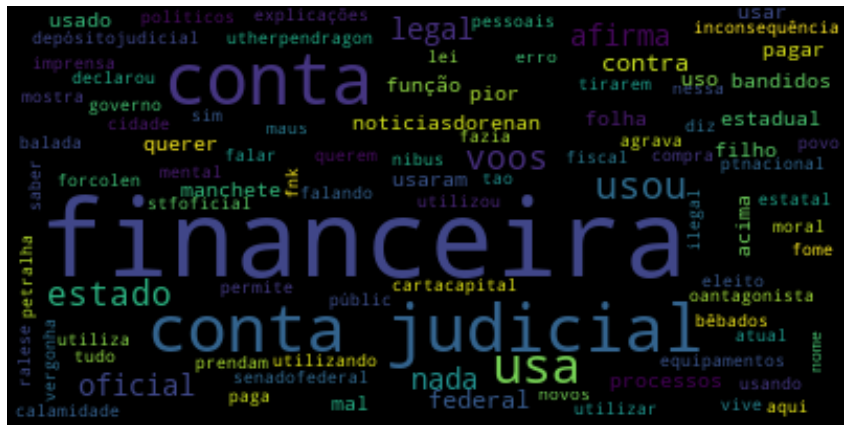

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = ' '.join(textblob_tweet_neg_train)
wordcloud = WordCloud().generate(text)

plt.figure(figsize = (15, 9))
# Display the generated image:
plt.imshow(wordcloud, interpolation= "bilinear")
plt.axis("off")
plt.show()

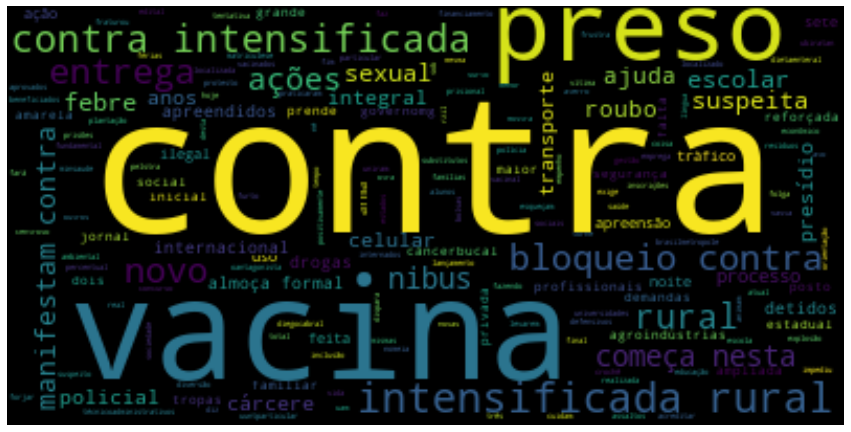

In [14]:
text = ' '.join(textblob_tweet_pos_train)
wordcloud = WordCloud().generate(text)

plt.figure(figsize = (15, 9))
# Display the generated image:
plt.imshow(wordcloud, interpolation= "bilinear")
plt.axis("off")
plt.show()

In [15]:
BOW_pos = nltk.FreqDist(textblob_tweet_pos_train)
print(BOW_pos)
BOW_neg = nltk.FreqDist(textblob_tweet_neg_train)
print(BOW_neg)
BOW_neg
BOW = nltk.FreqDist(all_words_train)

<FreqDist with 178 samples and 620 outcomes>
<FreqDist with 96 samples and 317 outcomes>


Pega as 100 palavras mais relevantes

In [16]:
from collections import OrderedDict
ordered_bow = OrderedDict(sorted(BOW.items(), key=lambda x: x[1],reverse=True))
word_features = list(ordered_bow.keys())[:100]
print(len(word_features),word_features)

100 ['contra', 'financeira', 'conta', 'presos', 'rural', 'judicial', 'vacina', 'intensificada', 'vacinas', 'bloqueio', 'entrega', 'usa', 'ações', 'nibus', 'novo', 'começa', 'nesta', 'manifestam', 'sexual', 'escolar', 'suspeita', 'febre', 'preso', 'ajuda', 'roubo', 'cárcere', 'policial', 'transporte', 'integral', 'presídio', 'anos', 'celular', 'usou', 'uso', 'processo', 'estado', 'voos', 'almoça', 'formal', 'novos', 'internacional', 'drogas', 'apreendidos', 'ilegal', 'estadual', 'detidos', 'afirma', 'nada', 'legal', 'oficial', 'feita', 'sete', 'noite', 'ação', 'apreensão', 'tráfico', 'federal', 'q', 'profissionais', 'social', 'mostra', 'ampliada', 'segurança', 'reforçada', 'maior', 'tropas', 'falta', 'familiar', 'agroindústrias', 'dois', 'jornal', 'diz', 'governomg', 'prende', 'inicial', 'privada', 'amarela', 'oantagonista', 'câncerbucal', 'arma', 'demandas', 'grande', 'atual', 'posto', 'folha', 'n', 'processos', 'usar', 'filho', 'pagar', 'função', 'bandidos', 'manchete', 'acima', 'usar

In [0]:
def find_features(tweet):
  words = TextBlob(tweet)
  features ={}
  for w in word_features:
    features[w] = (w in words)
  return features

Analisador de sentimentos que será utilizado posteriormente.

In [0]:
def sentiment(text, sentimentClassifier):
    feats = find_features(text)
    return sentimentClassifier.classify(feats)

In [0]:
import random

featuresets_train = [(find_features(rev), category) for (rev, category) in all_tweets_train]
random.shuffle(featuresets_train)
featuresets_test = [(find_features(rev), category) for (rev, category) in all_tweets_test]
random.shuffle(featuresets_test)

In [20]:
print(all_tweets_train[1])
print(featuresets_train[1])

('Governo de Minas lança 4ª edital de incentivo à inovação tecnológica e empreendedorismo', 'pos')
({'contra': False, 'financeira': False, 'conta': False, 'presos': False, 'rural': False, 'judicial': False, 'vacina': False, 'intensificada': False, 'vacinas': False, 'bloqueio': False, 'entrega': False, 'usa': False, 'ações': False, 'nibus': False, 'novo': False, 'começa': False, 'nesta': False, 'manifestam': False, 'sexual': False, 'escolar': False, 'suspeita': False, 'febre': False, 'preso': False, 'ajuda': False, 'roubo': False, 'cárcere': False, 'policial': False, 'transporte': False, 'integral': False, 'presídio': False, 'anos': False, 'celular': False, 'usou': False, 'uso': False, 'processo': False, 'estado': False, 'voos': False, 'almoça': False, 'formal': False, 'novos': False, 'internacional': False, 'drogas': False, 'apreendidos': False, 'ilegal': False, 'estadual': False, 'detidos': False, 'afirma': False, 'nada': False, 'legal': False, 'oficial': False, 'feita': False, 'sete'

In [21]:
training_set = featuresets_train
testing_set = featuresets_test
print('training_set : ', len(training_set), '\ntesting_set :', len(testing_set))

training_set :  1783 
testing_set : 640


##Treinando classificador NayveBayes

In [22]:
classifierNaiveBayes = nltk.NaiveBayesClassifier.train(training_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifierNaiveBayes, testing_set))*100)
classifierNaiveBayes.show_most_informative_features(15)

Classifier accuracy percent: 88.90625
Most Informative Features
                   febre = True              pos : neg    =     50.2 : 1.0
                 amarela = True              pos : neg    =     50.2 : 1.0
                   conta = True              neg : pos    =     48.0 : 1.0
                    dois = True              neg : pos    =     28.3 : 1.0
                   filho = True              neg : pos    =     27.0 : 1.0
                  presos = True              pos : neg    =     26.2 : 1.0
                    arma = True              pos : neg    =     19.2 : 1.0
                  prende = True              pos : neg    =     14.9 : 1.0
                   preso = True              pos : neg    =     13.8 : 1.0
                     usa = True              neg : pos    =     12.3 : 1.0
                    voos = True              neg : pos    =     12.3 : 1.0
                   ações = True              pos : neg    =     11.0 : 1.0
                presídio = True     

In [23]:
mif = classifierNaiveBayes.most_informative_features()
mif = [a for a,b in mif]
print(mif)

['febre', 'amarela', 'conta', 'dois', 'filho', 'presos', 'arma', 'prende', 'preso', 'usa', 'voos', 'ações', 'presídio', 'entrega', 'contra', 'segurança', 'bandidos', 'novo', 'ação', 'estado', 'anos', 'oficial', 'nada', 'n', 'diz', 'maior', 'q', 'nibus', 'uso', 'legal', 'ajuda', 'processo', 'atual', 'estadual', 'usado', 'mal', 'drogas', 'q', 'ilegal', 'jornal', 'financeira', 'dois', 'formal', 'mostra', 'preso', 'febre', 'amarela', 'afirma', 'roubo', 'ação', 'conta', 'contra', 'tráfico', 'judicial', 'novos', 'estado', 'presos', 'vacina', 'n', 'filho', 'prende', 'presídio', 'arma', 'falta', 'usa', 'anos', 'novo', 'ações', 'nibus', 'uso', 'voos', 'entrega', 'rural', 'folha', 'segurança', 'celular', 'suspeita', 'bloqueio', 'usou', 'vacinas', 'escolar', 'pagar', 'intensificada', 'detidos', 'oficial', 'apreensão', 'diz', 'usar', 'governomg', 'grande', 'maior', 'processo', 'ajuda', 'nesta', 'transporte', 'apreendidos', 'familiar', 'começa', 'legal', 'nada']


##Testando classifiador NayveBayes

In [0]:
ground_truth = [r[1] for r in testing_set]
preds = [classifierNaiveBayes.classify(r[0]) for r in testing_set]

In [25]:
acc = 0 
for i in range(100):
  if preds[i] != testing_set[i][1]:
    #print(preds[i])
    #print(testing_set[i])
    acc=acc+1
print("Erro:", acc)

Erro: 5


##F1 Score NayveBayes

In [26]:
from sklearn.metrics import f1_score
f1_score(ground_truth, preds, labels = ['neg', 'pos'], average = 'micro')

0.8890625

##Matriz de Confusão

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

##Matriz de Confusão NayveBayes

Confusion matrix, without normalization
[[175  55]
 [ 16 394]]
Normalized confusion matrix
[[0.76 0.24]
 [0.04 0.96]]


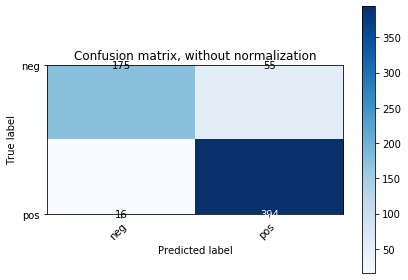

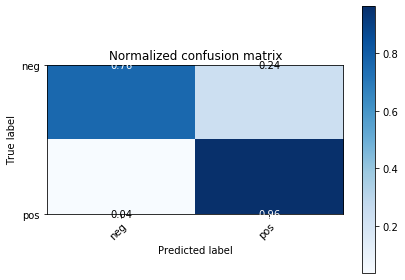

In [28]:
y_test = ground_truth
y_pred = preds
class_names = ['neg', 'pos']

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Testes com frases aleatorias do Twitter classificadas como positivas e negativas coletadas em 3/11/2019

In [29]:
#Positivas
print('Frases positivas do Twitter')
print(sentiment('Relaxa, vai valer a pena cada oração, cada joelho no chão, cada lágrima escorrida. ', classifierNaiveBayes))
print(sentiment('Deus é a esperança em meio a tempestade. (Jeremias 14:8)🙏🏻🍃💨', classifierNaiveBayes))
print(sentiment('Beijo na testa vai sempre continuar sendo a coisa mais fofa que existe!! ❤', classifierNaiveBayes))
print()
#Negativas
print('Frases negativas do Twitter')
print(sentiment('Relaxa, vai valer a pena cada oração, cada joelho no chão, cada lágrima escorrida. ', classifierNaiveBayes))
print(sentiment('Tomei banho e coloquei minha fantasia de mendigo,oops pijama. ', classifierNaiveBayes))
print(sentiment('vc trouxa q tira foto fumando cigarro pra tentar ser descolado saiba que no futuro a unica coisa que vai descolar é o pulmao do seu corpo', classifierNaiveBayes))

Frases positivas do Twitter
pos
pos
neg

Frases negativas do Twitter
pos
neg
pos


##Decision Tree Training

In [30]:
classifierDecisionTree = nltk.DecisionTreeClassifier.train(training_set)

print("Classifier accuracy percent:",(nltk.classify.accuracy(classifierDecisionTree, testing_set))*100)

Classifier accuracy percent: 85.9375


##Decising Tree Testing

In [0]:
ground_truth = [r[1] for r in testing_set]

preds = [classifierDecisionTree.classify(r[0]) for r in testing_set]

In [32]:
acc = 0 
for i in range(100):
  if preds[i] != testing_set[i][1]:
    #print(preds[i])
    #print(testing_set[i])
    acc=acc+1
print("erro:", acc)

erro: 13


##F1 Score Decision Tree

In [33]:
f1_score(ground_truth, preds, labels = ['neg', 'pos'], average = 'micro')

0.859375

##Matriz de Confusão Decision Tree

Confusion matrix, without normalization
[[150  80]
 [ 10 400]]
Normalized confusion matrix
[[0.65 0.35]
 [0.02 0.98]]


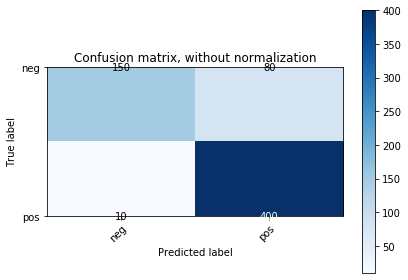

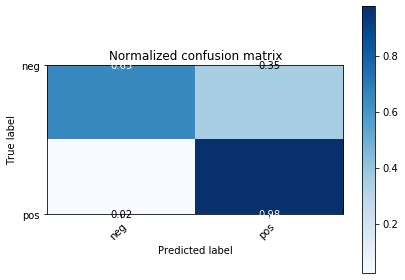

In [34]:
y_test = ground_truth
y_pred = preds
class_names = ['neg', 'pos']

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Testes com frases aleatorias do Twitter classificadas como positivas e negativas coletadas em 3/11/2019

In [35]:
#Positivas
print('Frases positivas do Twitter')
print(sentiment('Relaxa, vai valer a pena cada oração, cada joelho no chão, cada lágrima escorrida. ', classifierDecisionTree))
print(sentiment('Deus é a esperança em meio a tempestade. (Jeremias 14:8)🙏🏻🍃💨', classifierDecisionTree))
print(sentiment('Beijo na testa vai sempre continuar sendo a coisa mais fofa que existe!! ❤', classifierDecisionTree))
print()
#Negativas
print('Frases negativas do Twitter')
print(sentiment('Relaxa, vai valer a pena cada oração, cada joelho no chão, cada lágrima escorrida. ', classifierDecisionTree))
print(sentiment('Tomei banho e coloquei minha fantasia de mendigo,oops pijama. ', classifierDecisionTree))
print(sentiment('vc trouxa q tira foto fumando cigarro pra tentar ser descolado saiba que no futuro a unica coisa que vai descolar é o pulmao do seu corpo', classifierDecisionTree))

Frases positivas do Twitter
pos
pos
pos

Frases negativas do Twitter
pos
pos
pos


##Resultado

Podemos concluir que o classificador Nayve Bayes (88,9% de acerto) é melhor que o árvore de decisão (85,9%) quando não utilizando TextBlob. Isso pode ser constatado nos resultados da acuracia após testar o modelo quando utilizando F1 Score.


#Com TextBlob

In [0]:
textblob_tweet_pos_train = []
textblob_tweet_neg_train = []
textblob_tweet_pos_test = []
textblob_tweet_neg_test = []
all_tweets_train = []
all_words_train = []
all_tweets_test = []
all_words_test = []

allowed_word_types = ['J']

#Training data portion

for p in tweet_pos_train:
  all_tweets_train.append((p,'pos'))
  #print(p, TextBlob(p).sentiment) -- A maioria dos resultados tem polaridade e subjetividade igual a 0. 
  cleaned = re.sub(r'[^(a-zA-Záéíóúâêîôûàèìòùãõüç)\s]','',p)
  tokenized = TextBlob(cleaned).words.singularize()#.lemmatize()
  stopped = [w for w in tokenized if not w in stop_words]
  pos = nltk.pos_tag(stopped)
  for w in pos:
    if w[1][0] in allowed_word_types:
      textblob_tweet_pos_train.append(w[0].lower())
      all_words_train.append(w[0].lower())
for n in tweet_neg_train:
  all_tweets_train.append((n,'neg'))
  cleaned = re.sub(r'[^(a-zA-Záéíóúâêîôûàèìòùãõüç)\s]','',n)
  tokenized = TextBlob(cleaned).words.singularize()#.lemmatize()
  stopped = [w for w in tokenized if not w in stop_words]
  neg = nltk.pos_tag(stopped)
  for w in neg:
    if w[1][0] in allowed_word_types:
      textblob_tweet_neg_train.append(w[0].lower())
      all_words_train.append(w[0].lower())

#Testing Data Portion

for p in tweet_pos_test:
  all_tweets_test.append((p,'pos'))
  cleaned = re.sub(r'[^(a-zA-Záéíóúâêîôûàèìòùãõüç)\s]','',p)
  tokenized = TextBlob(cleaned).words.singularize()#.lemmatize()
  stopped = [w for w in tokenized if not w in stop_words]
  pos = nltk.pos_tag(stopped)
  for w in pos:
    if w[1][0] in allowed_word_types:
      textblob_tweet_pos_test.append(w[0].lower())
      all_words_test.append(w[0].lower())
for n in tweet_neg_test:
  all_tweets_test.append((n,'neg'))
  cleaned = re.sub(r'[^(a-zA-Záéíóúâêîôûàèìòùãõüç)\s]','',n)
  tokenized = TextBlob(cleaned).words.singularize()#.lemmatize()
  stopped = [w for w in tokenized if not w in stop_words]
  neg = nltk.pos_tag(stopped)
  for w in neg:
    if w[1][0] in allowed_word_types:
      textblob_tweet_neg_test.append(w[0].lower())
      all_words_test.append(w[0].lower())

In [37]:
print(TextBlob('infrações').words.singularize()) # não funciona para plural irregular em português
print(TextBlob('seriamos').words.lemmatize()) #Não funciona em portugues
print(TextBlob('infrações').detect_language())

['infraçõe']
['seriamos']
pt


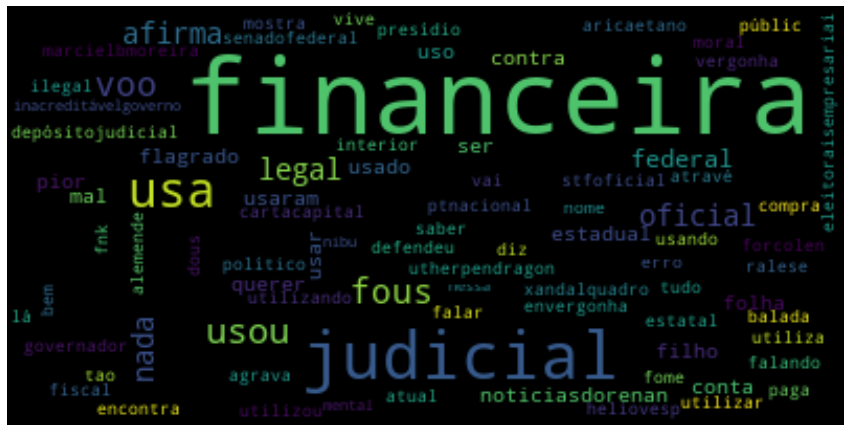

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = ' '.join(textblob_tweet_neg_train)
wordcloud = WordCloud().generate(text)

plt.figure(figsize = (15, 9))
# Display the generated image:
plt.imshow(wordcloud, interpolation= "bilinear")
plt.axis("off")
plt.show()

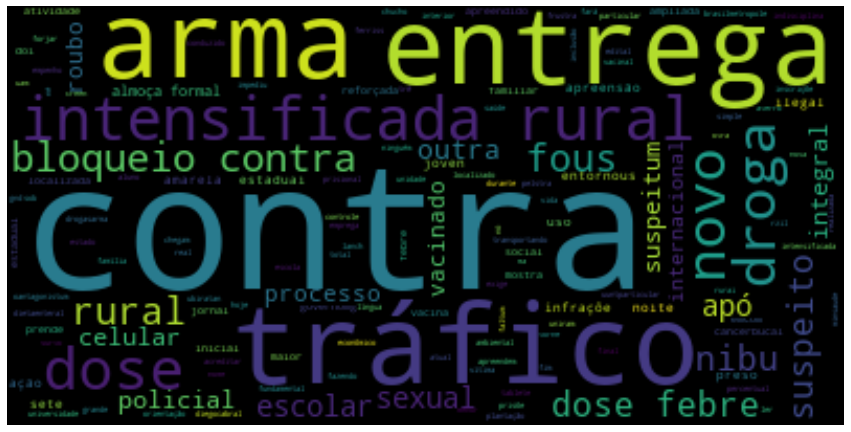

In [39]:
text = ' '.join(textblob_tweet_pos_train)
wordcloud = WordCloud().generate(text)

plt.figure(figsize = (15, 9))
# Display the generated image:
plt.imshow(wordcloud, interpolation= "bilinear")
plt.axis("off")
plt.show()

In [40]:
BOW_pos = nltk.FreqDist(textblob_tweet_pos_train)
print(BOW_pos)
BOW_neg = nltk.FreqDist(textblob_tweet_neg_train)
print(BOW_neg)
BOW_neg
BOW = nltk.FreqDist(all_words_train)

<FreqDist with 142 samples and 550 outcomes>
<FreqDist with 86 samples and 258 outcomes>


Pega as 100 palavras mais relevantes

In [41]:
from collections import OrderedDict
ordered_bow = OrderedDict(sorted(BOW.items(), key=lambda x: x[1],reverse=True))
word_features = list(ordered_bow.keys())[:100]
print(len(word_features),word_features)

100 ['contra', 'financeira', 'rural', 'dose', 'judicial', 'tráfico', 'arma', 'entrega', 'fous', 'intensificada', 'novo', 'bloqueio', 'droga', 'febre', 'usa', 'nibu', 'suspeito', 'apó', 'sexual', 'escolar', 'outra', 'policial', 'integral', 'celular', 'suspeitum', 'usou', 'vacinado', 'roubo', 'uso', 'processo', 'voo', 'almoça', 'formal', 'internacional', 'ilegal', 'estadual', 'afirma', 'nada', 'legal', 'oficial', 'preso', 'mostra', 'estaduai', 'sete', 'joven', 'entornous', 'infraçõe', 'noite', 'ação', 'apreensão', 'amarela', 'federal', 'q', 'social', 'ampliada', 'reforçada', 'maior', 'familiar', 'doi', 'apreendido', 'vacina', 'atividade', 'nome', 'jornal', 'governomg', 'emcom', 'prende', 'inicial', 'localizada', 'câncerbucal', 'interior', 'atual', 'ser', 'flagrado', 'folha', 'n', 'usar', 'filho', 'conta', 'usaram', 'usado', 'noticiasdorenan', 'pior', 'mal', 'querer', 'edital', 'econômico', 'menor', 'vida', 'família', 'torne', 'uuntparticular', 'faltum', 'empenho', 'brasilmetropole', 'ubi

Analisador de sentimentos que será utilizado posteriormente.

In [0]:
import random
featuresets_train = [(find_features(rev), category) for (rev, category) in all_tweets_train]
random.shuffle(featuresets_train)
featuresets_test = [(find_features(rev), category) for (rev, category) in all_tweets_test]
random.shuffle(featuresets_test)

In [43]:
print(all_tweets_train[1])
print(featuresets_train[1])

('Governo de Minas lança 4ª edital de incentivo à inovação tecnológica e empreendedorismo', 'pos')
({'contra': False, 'financeira': False, 'rural': False, 'dose': False, 'judicial': False, 'tráfico': True, 'arma': True, 'entrega': False, 'fous': False, 'intensificada': False, 'novo': False, 'bloqueio': False, 'droga': True, 'febre': False, 'usa': False, 'nibu': False, 'suspeito': False, 'apó': False, 'sexual': False, 'escolar': False, 'outra': False, 'policial': False, 'integral': False, 'celular': False, 'suspeitum': False, 'usou': False, 'vacinado': False, 'roubo': False, 'uso': False, 'processo': False, 'voo': False, 'almoça': False, 'formal': False, 'internacional': False, 'ilegal': True, 'estadual': False, 'afirma': False, 'nada': False, 'legal': True, 'oficial': False, 'preso': False, 'mostra': False, 'estaduai': False, 'sete': False, 'joven': False, 'entornous': False, 'infraçõe': False, 'noite': False, 'ação': False, 'apreensão': False, 'amarela': False, 'federal': False, 'q': 

In [44]:
training_set = featuresets_train
testing_set = featuresets_test
print('training_set : ', len(training_set), '\ntesting_set :', len(testing_set))

training_set :  1783 
testing_set : 640


##Treinando classificador NayveBayes

In [45]:
classifierNaiveBayes = nltk.NaiveBayesClassifier.train(training_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifierNaiveBayes, testing_set))*100)
classifierNaiveBayes.show_most_informative_features(15)

Classifier accuracy percent: 89.0625
Most Informative Features
                   febre = True              pos : neg    =     50.2 : 1.0
                 amarela = True              pos : neg    =     50.2 : 1.0
                   conta = True              neg : pos    =     48.0 : 1.0
                   filho = True              neg : pos    =     27.0 : 1.0
                     doi = True              neg : pos    =     25.8 : 1.0
                suspeito = True              pos : neg    =     23.8 : 1.0
                    arma = True              pos : neg    =     19.2 : 1.0
                  prende = True              pos : neg    =     14.9 : 1.0
                   preso = True              pos : neg    =     13.8 : 1.0
                     usa = True              neg : pos    =     12.3 : 1.0
                     voo = True              neg : pos    =     12.3 : 1.0
                     apó = True              pos : neg    =      8.9 : 1.0
                 entrega = True      

In [46]:
mif = classifierNaiveBayes.most_informative_features()
mif = [a for a,b in mif]
print(mif)

['febre', 'amarela', 'conta', 'filho', 'doi', 'suspeito', 'arma', 'prende', 'preso', 'usa', 'voo', 'apó', 'entrega', 'contra', 'menor', 'novo', 'ação', 'real', 'oficial', 'nada', 'n', 'família', 'maior', 'vida', 'q', 'nibu', 'uso', 'legal', 'processo', 'atual', 'estadual', 'nome', 'ser', 'usado', 'interior', 'mal', 'droga', 'q', 'ilegal', 'jornal', 'flagrado', 'financeira', 'doi', 'formal', 'mostra', 'preso', 'febre', 'amarela', 'afirma', 'roubo', 'ação', 'conta', 'contra', 'tráfico', 'judicial', 'vacina', 'n', 'filho', 'prende', 'suspeito', 'arma', 'usa', 'apó', 'ma', 'novo', 'ser', 'nibu', 'apreendido', 'uso', 'voo', 'ma', 'entrega', 'real', 'rural', 'dose', 'folha', 'celular', 'bloqueio', 'joven', 'usou', 'menor', 'escolar', 'vida', 'intensificada', 'oficial', 'apreensão', 'usar', 'governomg', 'maior', 'processo', 'vacinado', 'familiar', 'estaduai', 'legal', 'nada', 'apreendem', 'pior', 'federal', 'sexual', 'outra']


##Testando classifiador NayveBayes

In [0]:
ground_truth = [r[1] for r in testing_set]
preds = [classifierNaiveBayes.classify(r[0]) for r in testing_set]

In [48]:
acc = 0 
for i in range(100):
  if preds[i] != testing_set[i][1]:
    #print(preds[i])
    #print(testing_set[i])
    acc=acc+1
print("erro:", acc/100)

erro: 0.08


In [49]:
from sklearn.metrics import f1_score
f1_score(ground_truth, preds, labels = ['neg', 'pos'], average = 'micro')

0.890625

##Matriz de Confusão NayveBayes

Confusion matrix, without normalization
[[175  55]
 [ 15 395]]
Normalized confusion matrix
[[0.76 0.24]
 [0.04 0.96]]


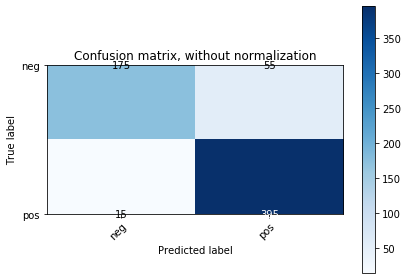

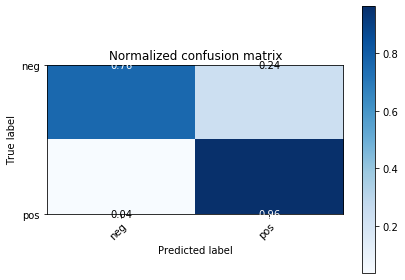

In [50]:
y_test = ground_truth
y_pred = preds
class_names = ['neg', 'pos']

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Testes com frases aleatorias do Twitter classificadas como positivas e negativas coletadas em 3/11/2019

In [51]:
#Positivas
print('Frases positivas do Twitter')
print(sentiment('Relaxa, vai valer a pena cada oração, cada joelho no chão, cada lágrima escorrida. ', classifierNaiveBayes))
print(sentiment('Deus é a esperança em meio a tempestade. (Jeremias 14:8)🙏🏻🍃💨', classifierNaiveBayes))
print(sentiment('Beijo na testa vai sempre continuar sendo a coisa mais fofa que existe!! ❤', classifierNaiveBayes))
print()
#Negativas
print('Frases negativas do Twitter')
print(sentiment('Relaxa, vai valer a pena cada oração, cada joelho no chão, cada lágrima escorrida. ', classifierNaiveBayes))
print(sentiment('Tomei banho e coloquei minha fantasia de mendigo,oops pijama. ', classifierNaiveBayes))
print(sentiment('vc trouxa q tira foto fumando cigarro pra tentar ser descolado saiba que no futuro a unica coisa que vai descolar é o pulmao do seu corpo', classifierNaiveBayes))

Frases positivas do Twitter
pos
pos
neg

Frases negativas do Twitter
pos
neg
pos


##Decision Tree Training

In [52]:
classifierDecisionTree = nltk.DecisionTreeClassifier.train(training_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifierDecisionTree, testing_set))*100)

Classifier accuracy percent: 85.15625


##Decising Tree Testing

In [0]:
ground_truth = [r[1] for r in testing_set]
preds = [classifierDecisionTree.classify(r[0]) for r in testing_set]

In [54]:
acc = 0 
for i in range(100):
  if preds[i] != testing_set[i][1]:
    #print(preds[i])
    #print(testing_set[i])
    acc=acc+1
print("erro:", acc/100)

erro: 0.12


##F1 Score Decision Tree

In [55]:
f1_score(ground_truth, preds, labels = ['neg', 'pos'], average = 'micro')

0.8515625

##Matriz de Confusão Decision Tree

Confusion matrix, without normalization
[[141  89]
 [  6 404]]
Normalized confusion matrix
[[0.61 0.39]
 [0.01 0.99]]


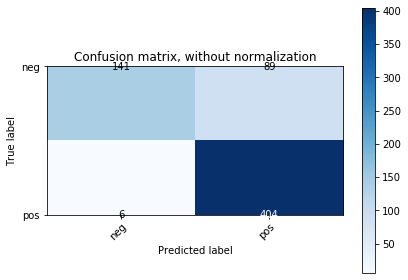

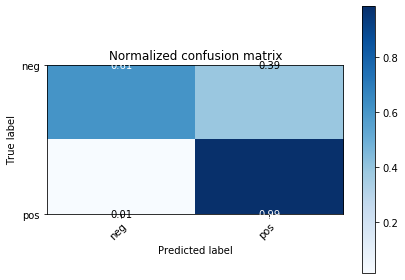

In [56]:
y_test = ground_truth
y_pred = preds
class_names = ['neg', 'pos']

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Testes com frases aleatorias do Twitter classificadas como positivas e negativas coletadas em 3/11/2019

In [57]:
#Positivas
print('Frases positivas do Twitter')
print(sentiment('Relaxa, vai valer a pena cada oração, cada joelho no chão, cada lágrima escorrida. ', classifierDecisionTree))
print(sentiment('Deus é a esperança em meio a tempestade. (Jeremias 14:8)🙏🏻🍃💨', classifierDecisionTree))
print(sentiment('Beijo na testa vai sempre continuar sendo a coisa mais fofa que existe!! ❤', classifierDecisionTree))

print()
#Negativas
print('Frases negativas do Twitter')
print(sentiment('Relaxa, vai valer a pena cada oração, cada joelho no chão, cada lágrima escorrida. ', classifierDecisionTree))
print(sentiment('Tomei banho e coloquei minha fantasia de mendigo,oops pijama. ', classifierDecisionTree))
print(sentiment('vc trouxa q tira foto fumando cigarro pra tentar ser descolado saiba que no futuro a unica coisa que vai descolar é o pulmao do seu corpo', classifierDecisionTree))

Frases positivas do Twitter
pos
pos
pos

Frases negativas do Twitter
pos
pos
pos


##Resultado

Novamente vemos a superioridade do Naive Bayes (89%) em comparação ao de arvore de decisão (85%). Considerando os resultados da rodada utilizando a classe nltk.tokenize para separação de palavras, a diferença para o classificador Naive Bayes é 0,1% em comparação com o TextBlob. Já diferença do classificador arvore de decisão é de 0,9% a favor do textblob. Sendo assim, na rodada atual (pois obtive resultados um pouco diferentes em outras rodadas dependendo dos dados sorteados para treinamento e teste) o melhor resultado é obtivido com o classificador Naive Bayes com nltk.tokenize.